In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

In [37]:
df = pd.read_csv("bmw.csv")
#df = df.drop(['Unnamed: 0'], axis = 1)
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0


In [39]:
i = [2,4]
df['test'] = "1"

df.iloc[i, df.columns.get_loc('test')] = "-1"
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,test
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0,1
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0,1
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0,-1
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5,1
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0,-1


In [64]:
def boxploting (data):
    sns.boxplot(data)
    
def scatterploting(x_data, y_data):
    # Scatter plot
    fig, ax = plt.subplots(figsize = (18,10))
    ax.scatter(x_data , y_data)
 
    # x-axis label
    ax.set_xlabel(x_data.name)
 
    # y-axis label
    ax.set_ylabel(y_data.name)
    plt.show()

    #This function use for scatterplot which highlight the anomalies
def scatterplot_with_color_coding(x_data, y_data, color_code_column, x_label, y_label, title):
    """
    Arguments:
        x_data: Series. Desired x-axis for scatterplot.
        y_data: Series. Desired y-axis for scatterplot.
        color_code_column: Series. Column to color-code data points in scatterplot by.
        x_label: String. Label for x-axis.
        y_label: String. Label for y-axis.
        title: String. Title of plot
    Outputs:
        Scatterplot in console.
    """
    fig, ax = plt.subplots()
    ax.scatter(x_data, y_data, c=color_code_column)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    fig.autofmt_xdate()
    
def statistical_z_value(df,clm):
    z = np.abs(stats.zscore(clm))
    # Position of the outlier
    index = np.where(z > 3)
    #print("Index of those value where z values are greater than 3 =",index ,"\n")
    
    #Generate column for statistical z value-detected anomalies
    df['stat_anomaly'] = "Normal"
    df.iloc[[index], df.columns.get_loc('stat_anomaly')] = "Outlier"
    
    return index, df



def IQR(df,clm):
    Q1 = np.percentile(clm, 25,
                   interpolation = 'midpoint')
 
    Q3 = np.percentile(clm, 75,
                   interpolation = 'midpoint')
    IQR = Q3 - Q1

    # Above Upper bound
    upper = clm >= (Q3+1.5*IQR)
 
    #print("Upper bound:",upper)
    upper_index = np.where(upper)
    #print("Upper index = ",np.where(upper),'\n')
 
    # Below Lower bound
    lower = clm <= (Q1-1.5*IQR)
    #print("Lower bound:", lower)
    lower_index =  np.where(lower)
    #print("Lower index ", np.where(lower),'\n')
    
    
    #Generate column for statistical z value-detected anomalies
    df['IQR_anomaly'] = "Normal"
    df.iloc[[upper_index], df.columns.get_loc('IQR_anomaly')] = "Outlier"
    df.iloc[[lower_index], df.columns.get_loc('IQR_anomaly')] = "Outlier"
    
    return upper_index, lower_index, df

In [101]:

class column_outlier_check:
    def __init__(self, data_frame,check_column, with_column):
        self.check_column = check_column
        self.with_column = with_column
        self.data_frame = data_frame
        
        self.indexes_based_on_z, self.new_df_with_stat = statistical_z_value(self.data_frame, self.check_column)
        self.upper_index , self.lower_index , self.new_df_with_iqr = IQR(self.data_frame, self.check_column)
        self.iqr_result_index = np.hstack((upper_index, lower_index))
        self.most_syspected_index = np.intersect1d(self.indexes_based_on_z, self.iqr_result_index)
        
        #boxploting(check_column)
        #scatterploting(check_column,with_column)
        
        
    def anomaly_check_based_on_z(self):
            self.data_frame['z_outlier'] = "Normal"
            self.data_frame.iloc[[self.indexes_based_on_z], self.data_frame.columns.get_loc('z_outlier')] = "Z value detected Outlier"
            sns.scatterplot(data=self.data_frame, x=self.with_column , y=self.check_column, hue="z_outlier")
    
    def anomaly_check_based_on_iqr(self):
        
            self.data_frame['iqr_outlier'] = "Normal"
            self.data_frame.iloc[[self.upper_index], self.data_frame.columns.get_loc('iqr_outlier')] = "IQR detected Outlier"
            self.data_frame.iloc[[self.lower_index], self.data_frame.columns.get_loc('iqr_outlier')] = "IQR detected Outlier"
            sns.scatterplot(data=self.data_frame, x=self.with_column , y=self.check_column, hue="iqr_outlier")
    
    def anomaly_check_based_on_both(self): 
            self.data_frame['z and iqr_outlier'] = "Normal"
            self.data_frame.iloc[[self.most_syspected_index], self.data_frame.columns.get_loc('z and iqr_outlier')] = "Z + IQR detected Outlier"
            sns.scatterplot(data=self.data_frame, x=self.with_column , y=self.check_column, hue="z and iqr_outlier")
            
            
           
           
            
        
  

# Mileage column

<AxesSubplot:xlabel='mileage', ylabel='year'>

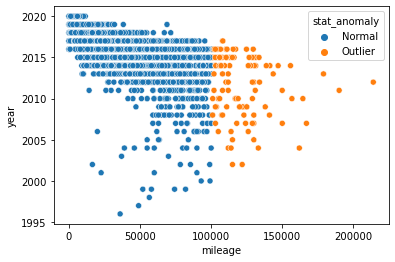

In [66]:
#statistical Z value
index, new_z_df = statistical_z_value(df,df["mileage"])
sns.scatterplot(data=new_z_df, x="mileage", y="year", hue="stat_anomaly")

<AxesSubplot:xlabel='mileage', ylabel='year'>

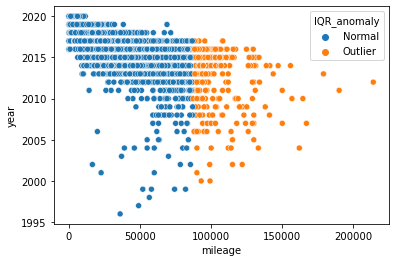

In [67]:
#IQR value
upper_index, lower_index, new_iqr_df = IQR(df,df["mileage"])
sns.scatterplot(data=new_iqr_df, x="mileage", y="year", hue="IQR_anomaly")

# mpg column

<AxesSubplot:xlabel='year', ylabel='mpg'>

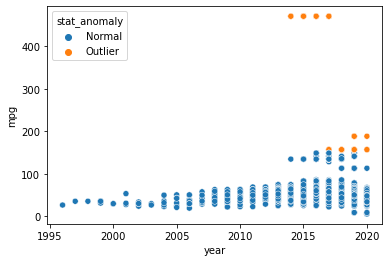

In [71]:
#statistical Z value
index, new_z_df = statistical_z_value(df,df["mpg"])
sns.scatterplot(data=new_z_df, x="year", y="mpg", hue="stat_anomaly")

<AxesSubplot:xlabel='year', ylabel='mpg'>

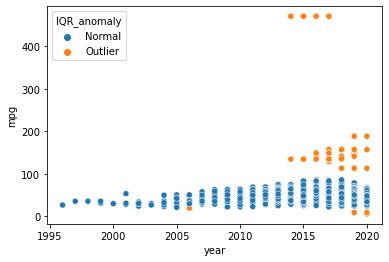

In [70]:
#IQR value
upper_index, lower_index, new_iqr_df = IQR(df,df["mpg"])
sns.scatterplot(data=new_iqr_df, x="year", y="mpg", hue="IQR_anomaly")

# Outlier check (Z_value, IQR, IQR+Z_value)

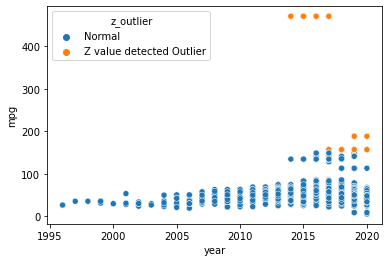

In [102]:
mpg_outlier = column_outlier_check(df, df['mpg'], df['year'])
mpg_outlier.anomaly_check_based_on_z()

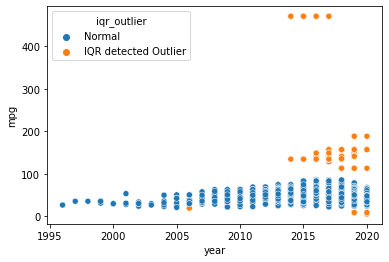

In [103]:
mpg_outlier.anomaly_check_based_on_iqr()


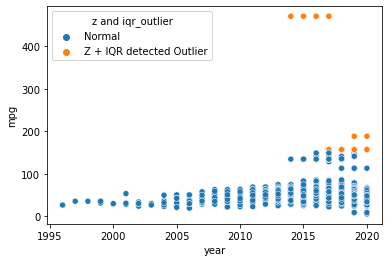

In [104]:
mpg_outlier.anomaly_check_based_on_both()